# Importing Modules

In [1]:
import numpy as np
import nibabel as nib                                                     
import itk                                                                
import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons

from skimage.util import montage 
from skimage.transform import rotate

%matplotlib inline
import seaborn as sns

import matplotlib.pyplot as plt

try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    plt.ion()


# Modules for model creation

In [2]:
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv3D, Dropout, Conv3DTranspose, Activation, BatchNormalization, concatenate, add
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing
from scipy.spatial.distance import directed_hausdorff
import cv2
import os
import tarfile

# Directory making & files extraction

In [3]:

# os.mkdir("brain_images")

In [4]:

# file = tarfile.open('braintumor_dataset\BraTS2021_Training_Data.tar')

# file.extractall('./brain_images')
# file.close()

# Loading an image from the dataset

In [5]:
image_path = "brain_images\BraTS2021_00000\BraTS2021_00000_t1.nii.gz"
image_obj = nib.load(image_path)
type(image_obj)

nibabel.nifti1.Nifti1Image

In [6]:
image_data = image_obj.get_fdata()
print(type(image_data))
image_data.shape

<class 'numpy.ndarray'>


(240, 240, 155)

# Real images Visualization

In [7]:
def visualize_3d(layer):
    plt.figure(figsize=(10, 5))
    plt.imshow(image_data[:, :, layer], cmap='gray');
    plt.axis('off')
    return layer

interact(visualize_3d, layer=(0, image_data.shape[2] - 1));

interactive(children=(IntSlider(value=77, description='layer', max=154), Output()), _dom_classes=('widget-inte…

# Visualization of segmented part of images

In [8]:
layer = 50


def visualize_3d_labels(layer):
    mask = nib.load('brain_images\BraTS2021_00000\BraTS2021_00000_seg.nii.gz').get_fdata()
    plt.imshow(mask[:,:,layer])
    plt.axis('off')
    plt.tight_layout()

interact(visualize_3d_labels, layer=(0, image_data.shape[2] - 1));

interactive(children=(IntSlider(value=77, description='layer', max=154), Output()), _dom_classes=('widget-inte…

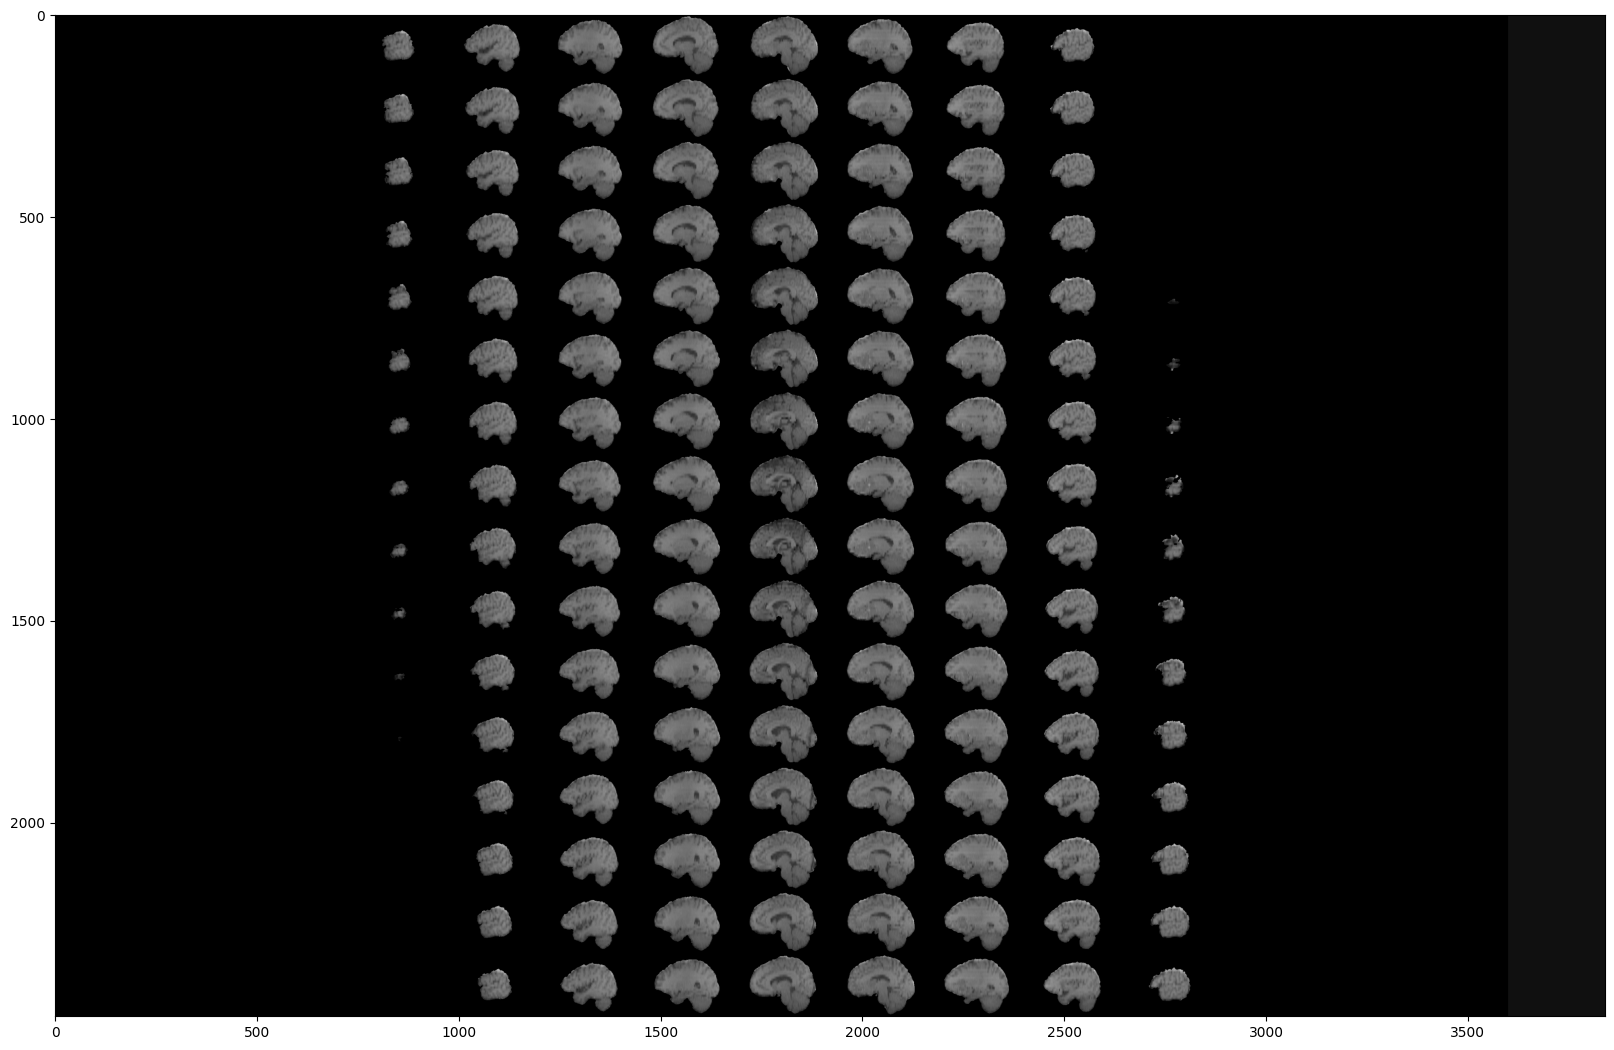

In [9]:
fig, ax1 = plt.subplots(1, 1, figsize = (20,20))
ax1.imshow(rotate(montage(image_data[:,:,:]), 90, resize=True), cmap ='gray')

In [10]:
# dice loss coef
def dice_coef(y_true, y_pred, epsilon=0.00001):
    axis = (0,1,2,3)
    numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    denominator = K.sum(y_true*y_true, axis=axis) + K.sum(y_pred*y_pred, axis=axis) + epsilon
    return K.mean((numerator)/(denominator))

# hausdorff dist
def hausdorff(y_true, y_pred):

    try:
        tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        pred_p = K.sum(K.round(K.clip(y_pred, 0, 1)))
        haussdorf_dist = tp -pred_p 
        return abs(haussdorf_dist/(128*128))
    except:
        return 1


# Precision 
def precision(y_true, y_pred):
        tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        pred_p = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = tp / (pred_p + K.epsilon())
        return precision

    
# Sensitivity      
def sensitivity(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possble_p = K.sum(K.round(K.clip(y_true, 0, 1)))
    return tp / (possble_p + K.epsilon())


#  Specificity
def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possble_n= K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return tn / (possble_n+ K.epsilon())

# Image pre-processing

### Creating new directories & storing training & validation data

In [11]:
image_size=128

In [12]:
# os.mkdir("val_brain_images")

In [13]:
Training_data_directory = 'brain_images'

In [14]:
# file = tarfile.open('braintumor_dataset\BraTS2021_00621.tar')
# file.extractall('./val_brain_images')
# file.close()

In [15]:
Validation_data_directoary = '../val_brain_images'

In [16]:
train_and_val_directories = [f.path for f in os.scandir(Training_data_directory) if f.is_dir()]
train_and_val_directories


['brain_images\\BraTS2021_00000',
 'brain_images\\BraTS2021_00002',
 'brain_images\\BraTS2021_00003',
 'brain_images\\BraTS2021_00005',
 'brain_images\\BraTS2021_00006',
 'brain_images\\BraTS2021_00008',
 'brain_images\\BraTS2021_00009',
 'brain_images\\BraTS2021_00011',
 'brain_images\\BraTS2021_00012',
 'brain_images\\BraTS2021_00014',
 'brain_images\\BraTS2021_00016',
 'brain_images\\BraTS2021_00017',
 'brain_images\\BraTS2021_00018',
 'brain_images\\BraTS2021_00019',
 'brain_images\\BraTS2021_00020',
 'brain_images\\BraTS2021_00021',
 'brain_images\\BraTS2021_00022',
 'brain_images\\BraTS2021_00024',
 'brain_images\\BraTS2021_00025',
 'brain_images\\BraTS2021_00026',
 'brain_images\\BraTS2021_00028',
 'brain_images\\BraTS2021_00030',
 'brain_images\\BraTS2021_00031',
 'brain_images\\BraTS2021_00032',
 'brain_images\\BraTS2021_00033',
 'brain_images\\BraTS2021_00035',
 'brain_images\\BraTS2021_00036',
 'brain_images\\BraTS2021_00043',
 'brain_images\\BraTS2021_00044',
 'brain_images

In [17]:
def fetchingDatafromPath(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = fetchingDatafromPath(train_and_val_directories); 

train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)

train_ids, test_ids = train_test_split(train_test_ids,test_size=0.05)

len(train_ids)

950

In [18]:

Total_image_slices = 128 
starting_image_slice = 22 

# Total_image_slices = 64 
# starting_image_slice = 50

# Model Creation

In [19]:
def CNN(input_mat,num_filters,kernel_size,batch_norm):
  # Input layer 
  inp = Conv3D(num_filters,kernel_size=(kernel_size,kernel_size,kernel_size),strides=(1,1,1),padding='same')(input_mat)
  # Starting batch normalization
  if batch_norm:
    inp = BatchNormalization()(inp)
  # Initiating activation function
  inp = Activation('relu')(inp)

  inp = Conv3D(num_filters,kernel_size=(kernel_size,kernel_size,kernel_size),strides=(1,1,1),padding='same')(inp)
  if batch_norm:
    inp = BatchNormalization()(inp)
  
  inp = Activation('relu')(inp)
    
  inp = add([input_mat,inp])
  
  return inp


def ThreeD_Vnet(input_img, n_filters = 8, dropout = 0.2, batch_norm = True):

  # Convolutional layer 1
  cnn1 = Conv3D(n_filters,kernel_size = (5,5,5) , strides = (1,1,1) , padding='same')(input_img)
  # Convolutional layer 2
  cnn2 = Conv3D(n_filters*2,kernel_size = (2,2,2) , strides = (2,2,2) , padding = 'same' )(cnn1)
  # Convolutional layer 3 
  cnn3 = CNN(cnn2 , n_filters*2,5,True)
  # Padding layer 
  pdd3 = Conv3D(n_filters*4,kernel_size = (2,2,2) , strides = (2,2,2), padding = 'same')(cnn3)
  pdd3 = Dropout(dropout)(pdd3)
  # Convolutional layer 4
  cnn4 = CNN(pdd3, n_filters*4,5,True)
  pdd4 = Conv3D(n_filters*8,kernel_size = (2,2,2) , strides = (2,2,2) , padding='same')(cnn4)
  pdd4 = Dropout(dropout)(pdd4)
  # Convolutional layer 5  
  cnn5 = CNN(pdd4, n_filters*8,5,True)
  pdd6 = Conv3D(n_filters*16,kernel_size = (2,2,2) , strides = (2,2,2) , padding='same')(cnn5)
  pdd6 = Dropout(dropout)(pdd6)
 
  pdd7 = CNN(pdd6,n_filters*16,5,True)
  # Convolutional layer 7  
  f6 = Conv3DTranspose(n_filters*8, (2,2,2), strides=(2, 2, 2), padding='same')(pdd7)
  f6 = concatenate([f6,cnn5])
  cnn7 = CNN(f6,n_filters*16,5,True)
  cnn7 = Dropout(dropout)(cnn7)
  u7 = Conv3DTranspose(n_filters*4,(2,2,2),strides = (2,2,2) , padding= 'same')(cnn7)

  # Convolutional layer 8
  u8 = concatenate([u7,cnn4])
  cnn8 = CNN(u8,n_filters*8,5,True)
  cnn8 = Dropout(dropout)(cnn8)
  f9 = Conv3DTranspose(n_filters*2,(2,2,2),strides = (2,2,2) , padding= 'same')(cnn8)
   # Convolutional layer 9 
  f9 = concatenate([f9,cnn3])
  cnn9 = CNN(f9,n_filters*4,5,True)
  cnn9 = Dropout(dropout)(cnn9)
  f10 = Conv3DTranspose(n_filters,(2,2,2),strides = (2,2,2) , padding= 'same')(cnn9)
  
  # Convolutional layer 10
  f10 = concatenate([f10,cnn1])
  cnn10 = Conv3D(n_filters*2,kernel_size = (5,5,5),strides = (1,1,1) , padding = 'same')(f10)
  cnn10 = Dropout(dropout)(cnn10)
  cnn10 = add([cnn10,f10])
  
  # Output layer 
  output = Conv3D(4, (1,1,1), activation='softmax')(cnn10)

  model = Model(inputs=input_img, outputs=output)

  return model

# Creating Data for model

In [20]:
keras = tf.compat.v1.keras
Sequence = keras.utils.Sequence

class CreatingModelData(Sequence):

    def __init__(self, list_IDs, dim=(image_size,image_size), batch_size = 1, n_channels = 4, shuffle=True):
       
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.ending_epoch()
        print("Total Modalities Used:", n_channels)

    def __len__(self):
        # batches in each epoch
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
       # batch initailizing
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # looking for ids list
        Batch_ids = [self.list_IDs[k] for k in indexes]

        X, y = self.__creating_data(Batch_ids)

        return X, y
    
    
    def getitem(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__creating_data(Batch_ids)

        return X, y

    def ending_epoch(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __creating_data(self, Batch_ids):
       
        X = np.zeros((self.batch_size*Total_image_slices, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*Total_image_slices, 128, 128))
        Y = np.zeros((self.batch_size*Total_image_slices, *self.dim, 4))

       
        
        # Creating data
        for c, i in enumerate(Batch_ids):

            case_path = os.path.join(Training_data_directory, i)

            xyz = os.listdir(i)
            xyz.sort()
            
            # Fetching t1 data
            data_path = os.path.join(i,xyz[2])
            t1 = nib.load(data_path).get_fdata() 

            # Fetching flair data
            data_path = os.path.join(i,xyz[0])
            flair = nib.load(data_path).get_fdata() 

            # Fetching t2 data
            data_path = os.path.join(i,xyz[4])
            t2 = nib.load(data_path).get_fdata()

            # Fetching t1ce data
            data_path = os.path.join(i,xyz[3])
            ce = nib.load(data_path).get_fdata()
  
            # Fetching seg data
            data_path = os.path.join(i,xyz[1]);
            seg = nib.load(data_path).get_fdata()
        
            for j in range(Total_image_slices):
                # print("A", end = " ")
                if self.n_channels > 0:
                    X[j+(Total_image_slices*c),:,:,0] = cv2.resize(t1[:,:,j+starting_image_slice], (image_size, image_size)) 

                if self.n_channels > 1:
                    X[j+(Total_image_slices*c),:,:,1] = cv2.resize(flair[:,:,j+starting_image_slice], (image_size, image_size))
                
                if self.n_channels > 2:
                    X[j+(Total_image_slices*c),:,:,2] = cv2.resize(t2[:,:,j+starting_image_slice], (image_size, image_size))

                if self.n_channels > 3:
                    X[j+(Total_image_slices*c),:,:,3] = cv2.resize(ce[:,:,j+starting_image_slice], (image_size, image_size))

                y[j +Total_image_slices*c,:,:] = cv2.resize(seg[:,:,j+starting_image_slice], (image_size, image_size))


        X = X.reshape(self.batch_size,128,128,128,self.n_channels)
        y = y.reshape(self.batch_size,128,128,128)

        # Generate masks
        y[y==4] = 3
        y = tf.one_hot(y, 4)

        return X/np.max(X), y


## Model1: Using all 4 modalities 

In [21]:
creating_training_data = CreatingModelData(train_ids, n_channels=4)
creating_validation_data = CreatingModelData(val_ids, n_channels=4)
creating_testing_data = CreatingModelData(test_ids, n_channels=4)

Total Modalities Used: 4
Total Modalities Used: 4
Total Modalities Used: 4


In [22]:
input_layer = Input((128,image_size, image_size, 4))

model1 = ThreeD_Vnet(input_layer)
model1.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4),
                                                                                                                dice_coef, precision, sensitivity, specificity, hausdorff] )

model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 4)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  4008        ['input_1[0][0]']                
                                8, 8)                                                             
                                                                                                  
 conv3d_1 (Conv3D)              (None, 64, 64, 64,   1040        ['conv3d[0][0]']                 
                                16)                                                           

In [23]:
if "yes" in input("Are you sure to Train Model? yes or no").lower():
    pass
else:
    raise Exception("Skip the next 6 Blocks and Run after that for directly showing Output")

Exception: Skip the next 6 Blocks and Run after that for directly showing Output

In [ ]:

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min', restore_best_weights=True)
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')

history =  model1.fit(creating_training_data, epochs=30, batch_size=4, steps_per_epoch= 200, validation_data = creating_validation_data, verbose=1, callbacks=[earlyStopping, mcp_save, reduce_lr_loss]) 
model1.save("model_vnet_4mod.h5")

Epoch 1/30
200/200 [==============================] - 282s 1s/step - loss: 0.0770 - accuracy: 0.9784 - mean_io_u: 0.4584 - dice_coef: 0.4222 - precision: 0.9836 - sensitivity: 0.9679 - specificity: 0.9964 - hausdorff: 1.3866 - val_loss: 0.6387 - val_accuracy: 0.9089 - val_mean_io_u: 0.3750 - val_dice_coef: 0.3687 - val_precision: 0.9657 - val_sensitivity: 0.8954 - val_specificity: 0.9897 - val_hausdorff: 3.9742 - lr: 0.0010
Epoch 2/30
200/200 [==============================] - 272s 1s/step - loss: 0.0485 - accuracy: 0.9875 - mean_io_u: 0.4256 - dice_coef: 0.4347 - precision: 0.9900 - sensitivity: 0.9858 - specificity: 0.9967 - hausdorff: 1.2793 - val_loss: 2.6662 - val_accuracy: 0.8087 - val_mean_io_u: 0.3750 - val_dice_coef: 0.2554 - val_precision: 0.8390 - val_sensitivity: 0.8007 - val_specificity: 0.9486 - val_hausdorff: 19.7348 - lr: 0.0010
Epoch 3/30
200/200 [==============================] - 268s 1s/step - loss: 0.0340 - accuracy: 0.9900 - mean_io_u: 0.3810 - dice_coef: 0.4827 - 

In [ ]:
print("Evaluate on test data")
results = model1.evaluate(creating_testing_data)
print("test loss, test acc:", results)

Evaluate on test data
50/50 [==============================] - 29s 572ms/step - loss: 0.1978 - accuracy: 0.9675 - mean_io_u: 0.3876 - dice_coef: 0.4155 - precision: 0.9769 - sensitivity: 0.9657 - specificity: 0.9926 - hausdorff: 2.8350
test loss, test acc: [0.1978176236152649, 0.9675325751304626, 0.3875681757926941, 0.415546715259552, 0.9769306778907776, 0.9657254815101624, 0.9926173686981201, 2.834965705871582]


# Model Accuracy Graph

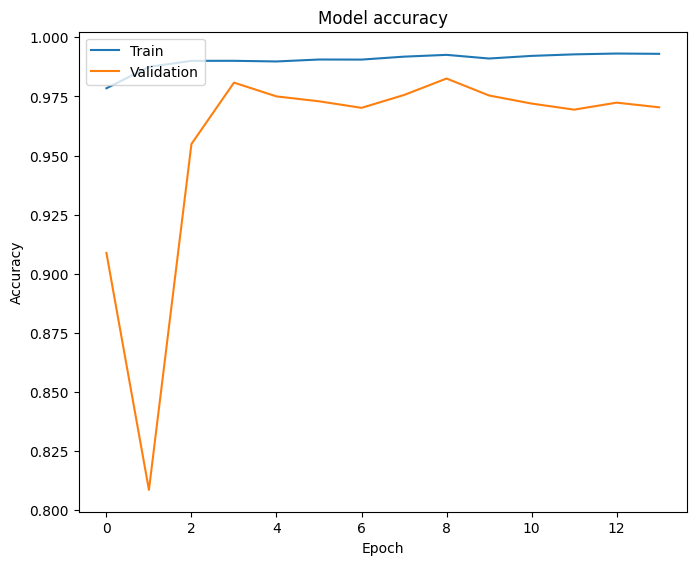

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,wspace=0.35)
plt.show()

# Model Loss Graph

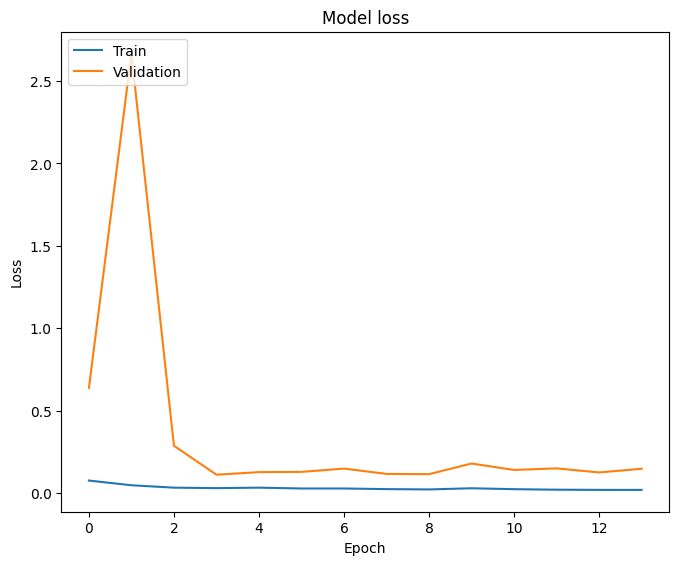

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

# Model Dice Coef Graph

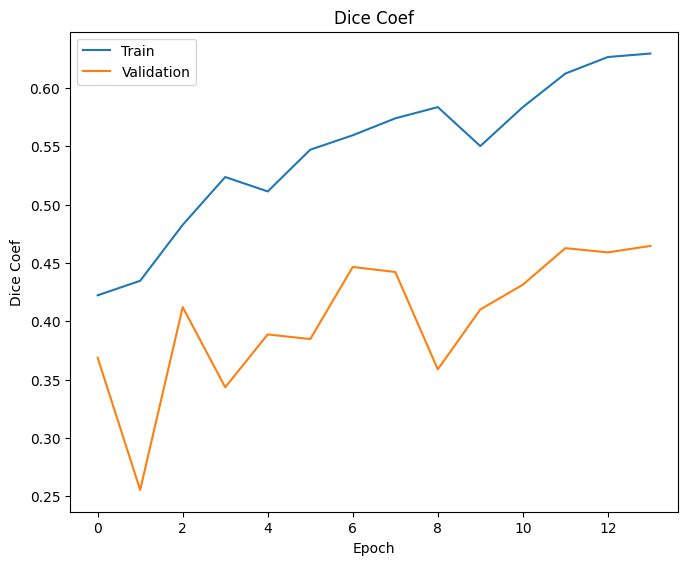

In [ ]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Dice Coef')
plt.ylabel('Dice Coef')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,wspace=0.35)
plt.show()

# Model Hausdroff Dist Graph

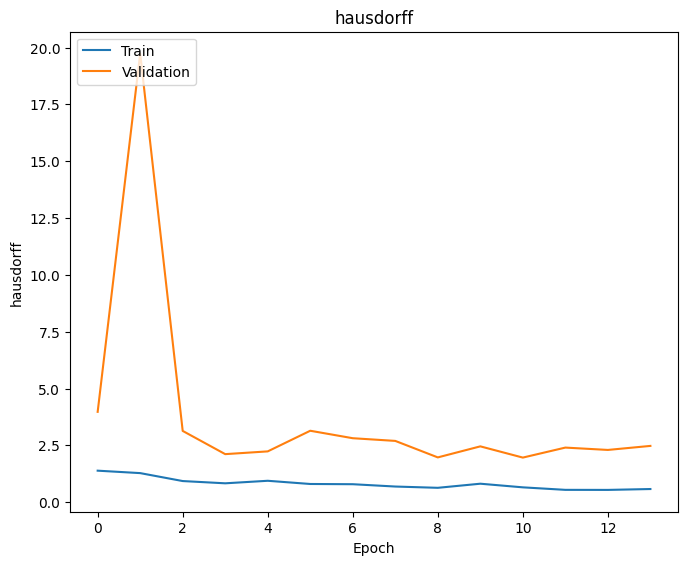

In [ ]:
plt.plot(history.history['hausdorff'])
plt.plot(history.history['val_hausdorff'])
plt.title('hausdorff')
plt.ylabel('hausdorff')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,wspace=0.35)
plt.show()

## Training completed for all modalities model

# **********************************************************

# Loading the all modalities Pre-Trained model (Run From Here for showing Run Output)

In [24]:
loaded_model_all = keras.models.load_model('model_vnet_4mod.h5', compile=False)
op = loaded_model_all.predict(creating_testing_data)

50/50 [==============================] - 34s 567ms/step


# Result

# Input Real image

In [33]:
image_num = 44

In [34]:
inp_test = np.array(creating_testing_data.getitem(image_num)[0])
inp_test.shape
inp_test = tf.convert_to_tensor(inp_test, dtype=float, name='inp_test')
inp_test.shape

TensorShape([1, 128, 128, 128, 4])

In [35]:
def visualise_flair(layer):
    mask = inp_test[0]
    plt.imshow(mask[:,:,layer,0],cmap ='bone')
    plt.axis('off')
    plt.tight_layout()

interact(visualise_flair, layer=(0, inp_test[0].shape[2] - 1))


interactive(children=(IntSlider(value=63, description='layer', max=127), Output()), _dom_classes=('widget-inte…

<function __main__.visualise_flair(layer)>

# Segmented part of image

In [36]:
seg_test = creating_testing_data.getitem(image_num)[1]
seg_test.shape

TensorShape([1, 128, 128, 128, 4])

In [37]:

def visualise_seg(layer):
    mask = seg_test[0]
    print(mask[:,:,layer].shape)
    plt.imshow(mask[:,:,layer])
    plt.axis('off')
    plt.tight_layout()

 

interact(visualise_seg, layer=(0, seg_test[0].shape[2] - 1))

interactive(children=(IntSlider(value=63, description='layer', max=127), Output()), _dom_classes=('widget-inte…

<function __main__.visualise_seg(layer)>

# Model predicted image

In [38]:

def visualize_pred(layer):
    mask = op[image_num]
    print(mask[:,:,layer].shape)
    plt.imshow((mask[:,:,layer])*1)
    plt.axis('off')
    plt.tight_layout()


interact(visualize_pred, layer=(0, op[image_num].shape[2] - 1))

interactive(children=(IntSlider(value=63, description='layer', max=127), Output()), _dom_classes=('widget-inte…

<function __main__.visualize_pred(layer)>